# 2. The different model classes

This section will show you the different models implemented in HMP

First we simulate the data by calling the `demo` function, which is only used for this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Running the demo function in the simulation module
from hmp.simulations import demo
n_events = 5 #how many events to simulate
epoch_data, sim_source_times, info = demo(1, n_events, seed=123, overwrite=False) #You can change the seed and the overwrite argument if you want to play around with other random data

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active


/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/simulations.py:220: UserWarning: /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/demo_dataset_raw.fif exists no new simulation performed
  warn(f"{subj_file} exists no new simulation performed", UserWarning)


Processing participant /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/demo_dataset_raw.fif's raw eeg
50 trials were retained for participant /home/gabriel/ownCloud/projects/RUGUU/hmp/docs/source/notebooks/sample_data/demo_dataset_raw.fif


We preprocess the data as in Turorial 1 and we want 3 PC components (more on that for the next tutorial on real data):

In [2]:
from hmp.preprocessing import Standard
preprocessed = Standard(epoch_data, n_comp=3)
preprocessed.data

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/preprocessing.py:165: UserWarning: Data will be modified inplace, re-read the data or use copy=True if multiplecalls to this function
  warn(


<xarray.DataArray (component: 3, all_samples: 3566)> Size: 86kB
array([[ 0.53560972,  0.19850657,  0.17567327, ...,  0.17766308,
         0.40572942,  0.47067545],
       [ 0.38244396,  0.56102823,  0.0798658 , ...,  0.88318528,
         1.45360032,  0.9394444 ],
       [-0.02622281, -0.14054032, -0.76716713, ..., -0.42271811,
        -0.50342972, -0.20295509]], shape=(3, 3566))
Coordinates:
    event_name   (all_samples) object 29kB 'stimulus' 'stimulus' ... 'stimulus'
    rt           (all_samples) float64 29kB 0.79 0.79 0.79 ... 0.77 0.77 0.77
  * component    (component) int64 24B 0 1 2
  * all_samples  (all_samples) object 29kB MultiIndex
  * participant  (all_samples) <U2 29kB 'S0' 'S0' 'S0' 'S0' ... 'S0' 'S0' 'S0'
  * epoch        (all_samples) int64 29kB 0 0 0 0 0 0 0 ... 49 49 49 49 49 49 49
  * sample       (all_samples) int64 29kB 0 1 2 3 4 5 6 ... 72 73 74 75 76 77 78
Attributes:
    sfreq:    100.0
    offset:   2

And we create a standard template and distribution as in Tutorial 1, this will be used for all the model classes

In [3]:
from hmp.patterns import HalfSine
from hmp.trialdata import TrialData

event_properties = HalfSine.create_expected(sfreq=epoch_data.sfreq)
trial_data = TrialData.from_preprocessed(preprocessed=preprocessed, pattern=event_properties.template)

## Model with a fixed number of event with `EventModel`

This type of model is the *basic* model used by HMP. All subsequent ones call this class implicitely.
The model works with an a priori number of events defined in the `n_events` parameter

The EM algorithm (see previous documentation section [here](./1-How_HMP_works.ipynb)) is initiated with the starting point that all events are spread out evenly across the mean reaction time (RT) and that no channels are contributing to the events

In [4]:
from hmp.models import EventModel

model_null = EventModel(event_properties, n_events=n_events,
                        max_iteration=0)#max_iteration=0 prevents from actually going through the EM
model_null.fit(trial_data, verbose=False)# Just to illustrate the default starting points

/home/gabriel/ownCloud/projects/RUGUU/hmp/hmp/models/event.py:559: RuntimeWarning: Convergence failed, estimation hit the maximum number of iterations: (0)
  warn(


In [5]:
model_null.time_pars

array([[[2.        , 5.94333333],
        [2.        , 5.94333333],
        [2.        , 5.94333333],
        [2.        , 5.94333333],
        [2.        , 5.94333333],
        [2.        , 5.94333333]]])

In [6]:
model_null.channel_pars

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

### Fit transform

As seen previously, when fitting an `EventModel` both the time and channel parameters will get updated depending on the data. The time parameters will be updated to reflect the expected time interval between each event, and the channel parameters will be updated to reflect the expected contribution of each channel to each event.

In [7]:
model = EventModel(event_properties, n_events=n_events)

#Fitting
loglikelihood, estimates = model.fit_transform(trial_data)# Fits the model and returns the estimates as event probabilities per sample

Estimating 5 events model with 1 starting point(s)


Combined, these time and channel parameters define the event probabilities for each sample in the data. 

The `estimates` variable contains these probabilities, which can be visualized using the `plot_topo_timecourse` function.

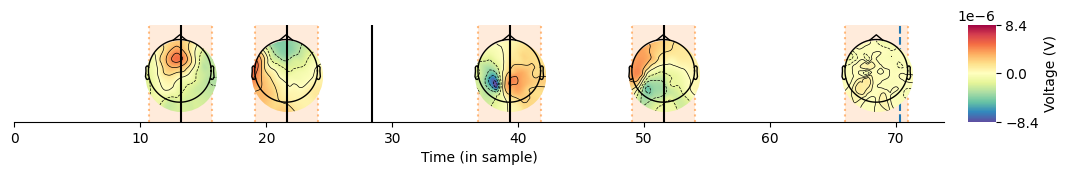

In [8]:
from hmp.visu import plot_topo_timecourse
#Visualizing
plot_topo_timecourse(epoch_data, estimates, info, magnify=1, sensors=False, times_to_display=None)
plt.vlines(np.mean(np.cumsum(sim_source_times,axis=1),axis=0)[:-1], 
           np.repeat(0,n_events), np.repeat(1,n_events), zorder=10, color='k')

In this case HMP misses the 3rd event, which is not surprising as it is very close to the 2nd one. The reason is that the EM algorithm is sensitive to the starting points given to the relative event onsets. By default, the `fit` method uses the starting point we illustrated above. We know that the last event is not at the RT so we could for example fix that parameter to avoid it being updated

## Fixing parameters

In [9]:
model_fixed = EventModel(event_properties, n_events=n_events, fixed_time_pars= [5], fixed_channel_pars=[4])

#Fitting
ll_fixed, estimates_fixed = model_fixed.fit_transform(trial_data)# Fits the model and returns the estimates as event probabilities per sample

Estimating 5 events model with 1 starting point(s)


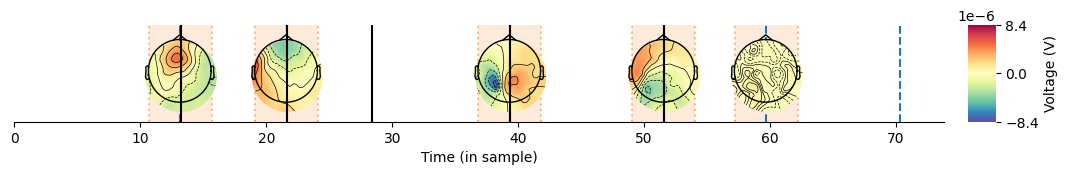

In [10]:
#Visualizing
plot_topo_timecourse(epoch_data, estimates_fixed, info, magnify=1, sensors=False)
plt.vlines(np.mean(np.cumsum(sim_source_times,axis=1),axis=0)[:-1], 
           np.repeat(0,n_events), np.repeat(1,n_events), zorder=10, color='k')

This doesn't help as the 3rd event is still not found. The main reason why the HMP fit fails here is because the actual placement of the true events and the starting points are not appropriately exploring the parameter space. We could give a better guess for these starting points

## Informed starting points

In [11]:
time_parameters = np.array([[[[2.        , 5.94333333],
                        [2.        , 5.94333333],
                        [2.        , 0.94333333],# Expecting a shorter inter-event duration
                        [2.        , 5.94333333],
                        [2.        , 5.94333333],
                        [2.        , 10.94333333]]]])# Expecting a longer inter-event duration
# Estimating an informed model
ll_informed, estimates_informed = model.fit_transform(trial_data, time_pars=time_parameters)# Providing the informed starting points

Estimating 5 events model


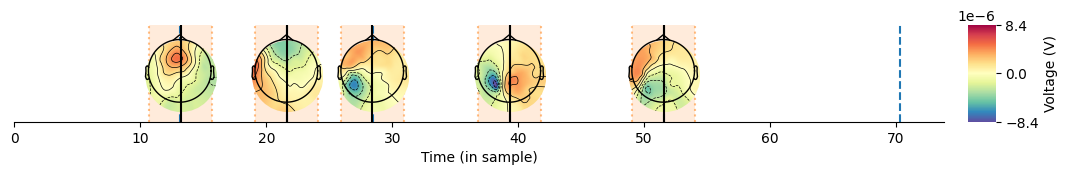

In [12]:
#Visualizing
plot_topo_timecourse(epoch_data, estimates_informed, info, magnify=1, sensors=False)
plt.vlines(np.mean(np.cumsum(sim_source_times,axis=1),axis=0)[:-1], 
           np.repeat(0,n_events), np.repeat(1,n_events), zorder=10, color='k')

Hooray, the 3rd event is now found! The reason is that the starting points are now more appropriate for the data. However, this is not always possible to know in advance, so we will now look at how to use random starting points.

## Random starting points

Here we will just generate random time parameters to avoid leaving parameter space unexplored.

In [13]:
model_random = EventModel(event_properties, n_events=n_events,
                        starting_points=100, max_scale=trial_data.durations.max())
ll_random, estimates_random = model_random.fit_transform(trial_data, cpus=10, )

Estimating 5 events model with 100 starting point(s)


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=45644) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


  0%|          | 0/101 [00:00<?, ?it/s]

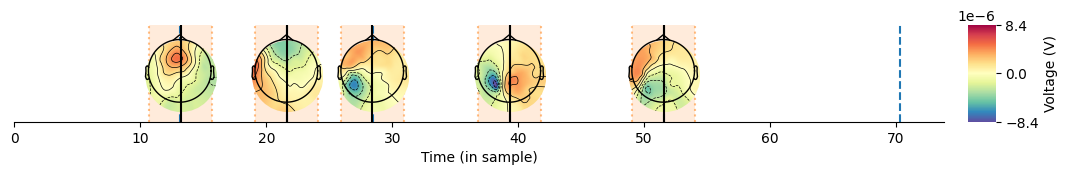

In [14]:
from hmp.visu import plot_topo_timecourse
#Visualizing
plot_topo_timecourse(epoch_data, estimates_random, info, magnify=1, sensors=False)
plt.vlines(np.mean(np.cumsum(sim_source_times,axis=1),axis=0)[:-1], 
           np.repeat(0,n_events), np.repeat(1,n_events), zorder=10, color='k')

As you can see, the method discovered all events. But random starting points are not always the best solution, especially when the number of events is high or if the duration you model (e.g. RT) is very long. In that case, we can use the eliminative or cumulative estimation methods.

## Eliminative method

Another solution is to first estimate a model with the maximal number of possible events that fit in RTs (referred to as 'the maximal model'), and then decrease the number of events one by one.

The idea is that genuine events will necessarily be found at the expected locations in the maximal model. Because the backward estimation method iteratively removes the weakest event (in terms of likelihood), only the 'strongest' events remain even if their location would have been hard to find with a single fit and default starting values.

In order to do this we will use the ```EliminativeMethod```. This function first estimates the maximal number of event (defined based on the event width and the minimum reaction time)  using an ```EventModel```, then estimates the max_event - 1 solution by iteratively removing one of the events and picking the solution with the highest likelihood (for more details see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_hmp_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 event solution is reached. 

### Default behavior

In [15]:
from hmp.models import EliminativeMethod

elim_model = EliminativeMethod(event_properties)
ll_elim, estimates_elim = elim_model.fit_transform(trial_data)

Estimating all solutions for maximal number of events (10)
Estimating all solutions for 9 events
Estimating all solutions for 8 events
Estimating all solutions for 7 events
Estimating all solutions for 6 events
Estimating all solutions for 5 events
Estimating all solutions for 4 events
Estimating all solutions for 3 events
Estimating all solutions for 2 events
Estimating all solutions for 1 events


Here we plot the resulting solutions going from the maximal possible number of events (here 10 given the simulated average RT) all the way to a single event. 

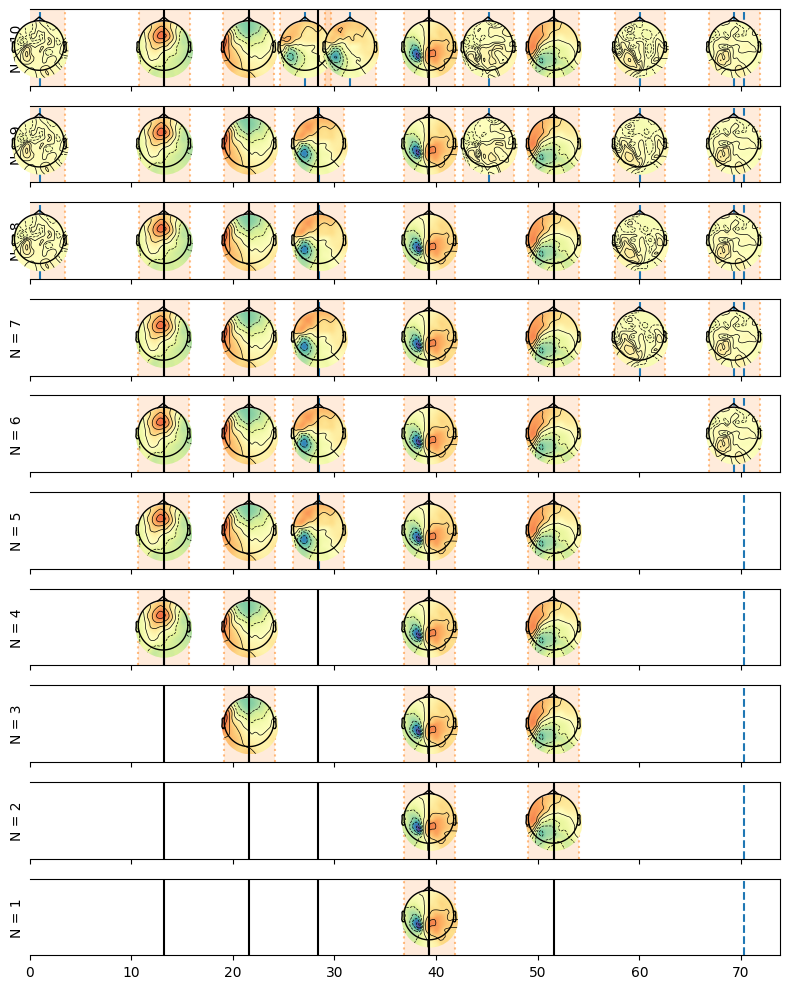

In [16]:
fig, axes = plt.subplots(len(estimates_elim.n_events), 1, figsize=(8, len(estimates_elim.n_events)), sharex=True)
for ax, n_event in zip(axes, estimates_elim.n_events):
    plot_topo_timecourse(epoch_data, estimates_elim.sel(n_events=n_event), info, sensors=False, magnify=1, ax=ax, colorbar=False)
    ax.vlines(np.mean(np.cumsum(sim_source_times, axis=1), axis=0)[:-1],
              np.repeat(0, n_events), np.repeat(1, n_events), zorder=10, color='k')
    ax.set_ylabel(f"N = {n_event.values}")
plt.tight_layout()

We can see that the maximal model contains the true topograpies and also some false alarms as we requested too many events compared to the true ones. We see that at each removal one of these false alarm gets removed.

From the solutions of the backward estimation we can select the number of events we originally wanted to estimate.

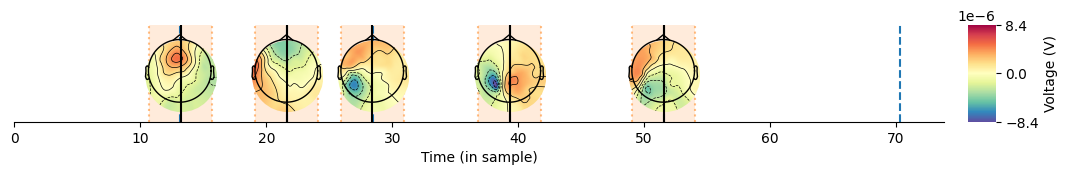

In [17]:
selected = estimates_elim.sel(n_events=n_events)
plot_topo_timecourse(epoch_data, selected, info, sensors=False)
plt.vlines(np.mean(np.cumsum(sim_source_times,axis=1),axis=0)[:-1], 
           np.repeat(0,n_events), np.repeat(1,n_events), zorder=10, color='k')

Note however that this is not the maximum likelihood solution, in fact in this example if we look at the log-likelihood of the different solutions we can see that the maximum likelihood solution is actually the 6 events solution as seen in the plot below. The likelihood is evolving in a complex manner with the number of events. On the one hand adding events tends to increase the likelihood, on the other hand if events start to compete for samples (see the maximum model where the third event is split in two), the likelihood can decrease. This is why we can see that the likelihood is not monotonically increasing with the number of events.

Text(0, 0.5, 'Log-likelihood')

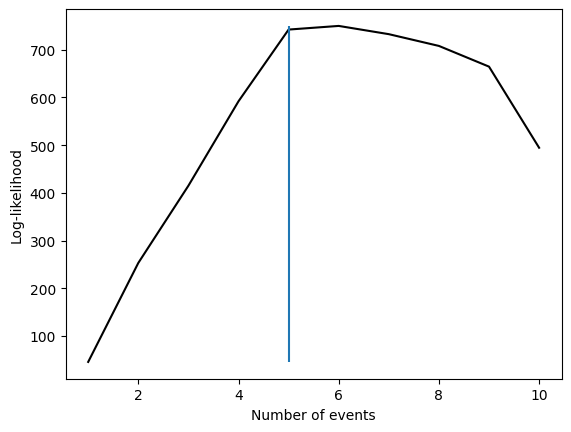

In [18]:
n_events_backward = [elim_model.submodels[i].n_events for i in elim_model.submodels]
plt.plot(n_events_backward, ll_elim, 'k')
plt.vlines(n_events, np.min(ll_elim), np.max(ll_elim))
plt.xlabel('Number of events')
plt.ylabel('Log-likelihood')

### Providing a custom maximum model

Instead of re-estimating a model with a maximum bumber of events we can provide a custom maximum model. This is useful if we know that the maximum number of events is lower than the one estimated by the `EliminativeMethod` class or if we want to depart from a specific model. In this case, we can provide a custom `EventModel` to the `EliminativeMethod` class and start the elimination from there.

In [19]:
elim_model_custom = EliminativeMethod(event_properties,  base_fit=model)
ll_elim_custom, estimates_elim_custom = elim_model_custom.fit_transform(trial_data)#Here we use the `model` we fitted above as the base model

Estimating all solutions for 4 events
Estimating all solutions for 3 events
Estimating all solutions for 2 events
Estimating all solutions for 1 events


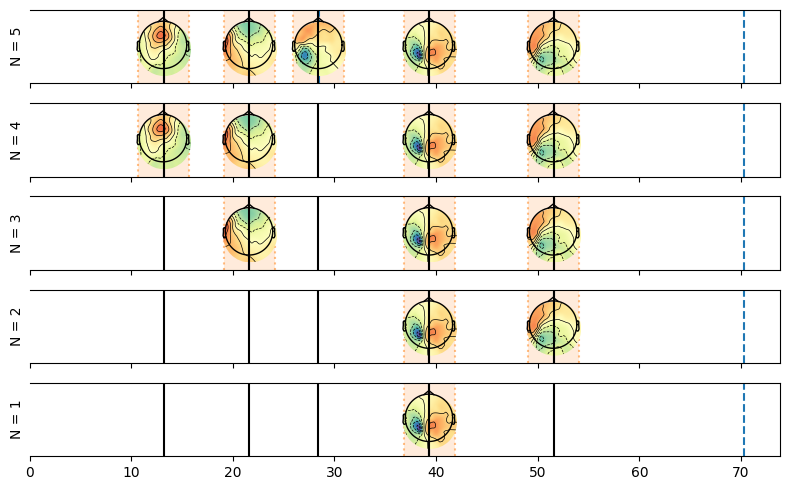

In [20]:
fig, axes = plt.subplots(len(estimates_elim_custom.n_events), 1, figsize=(8, len(estimates_elim_custom.n_events)), sharex=True)
for ax, n_event in zip(axes, estimates_elim_custom.n_events):
    plot_topo_timecourse(epoch_data, estimates_elim_custom.sel(n_events=n_event), info, sensors=False, magnify=1, ax=ax, colorbar=False)
    ax.vlines(np.mean(np.cumsum(sim_source_times, axis=1), axis=0)[:-1],
              np.repeat(0, n_events), np.repeat(1, n_events), zorder=10, color='k')
    ax.set_ylabel(f"N = {n_event.values}")
plt.tight_layout()

### Define a range

Alternatively we can also specify a range if we don't want to fully explore all solutions:

In [21]:
elim_model_range = EliminativeMethod(event_properties, max_events=8, min_events=3)
ll_range, estimates_range = elim_model_range.fit_transform(trial_data)

Estimating all solutions for maximal number of events (8)
Estimating all solutions for 7 events
Estimating all solutions for 6 events
Estimating all solutions for 5 events
Estimating all solutions for 4 events


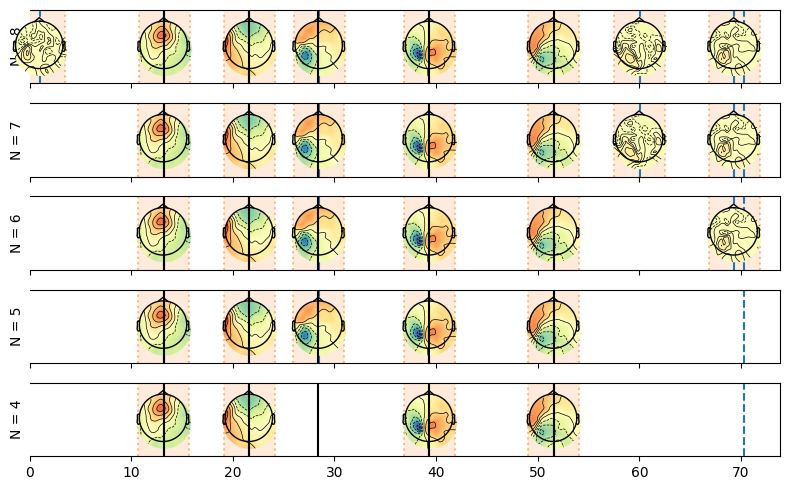

In [22]:
fig, axes = plt.subplots(len(estimates_range.n_events), 1, figsize=(8, len(estimates_range.n_events)), sharex=True)
for ax, n_event in zip(axes, estimates_range.n_events):
    plot_topo_timecourse(epoch_data, estimates_range.sel(n_events=n_event), info, sensors=False, magnify=1, ax=ax, colorbar=False)
    ax.vlines(np.mean(np.cumsum(sim_source_times, axis=1), axis=0)[:-1],
              np.repeat(0, n_events), np.repeat(1, n_events), zorder=10, color='k')
    ax.set_ylabel(f"N = {n_event.values}")
plt.tight_layout()

## Cumulative event fit

Instead of fitting an _n_ event model this method starts by fitting a 1 event model using each sample from the time 0 (stimulus onset) to the mean RT. Therefore it tests for the landing point of the expectation maximization algorithm given each sample as starting point and the likelihood associated with this landing point. As soon as a starting points reaches the convergence criterion, the function fits an _n+1_ event model and uses the next samples in the RT for the following event, etc.

In [23]:
from hmp.models import CumulativeMethod

### Default behavior

In [24]:
model_cumulative = CumulativeMethod(event_properties)
ll_cumulative, estimates_cumulative = model_cumulative.fit_transform(trial_data)

  0%|          | 0/71 [00:00<?, ?it/s]

Transition event 1 found around time 130.0
Transition event 2 found around time 220.0
Transition event 3 found around time 390.0
Transition event 4 found around time 520.0

All events found, refitting final combination.
Estimating 4 events model


The following cell displays what happened when we fitted the model, as you can see the model iteratively adds events to the model, starting with the one event and a proposal at the first sample, after this event reached a local maxima, the algorithm adds another event just after until convergence, etc. Any additional event that decreases likelihood gets rejected (see the last row).

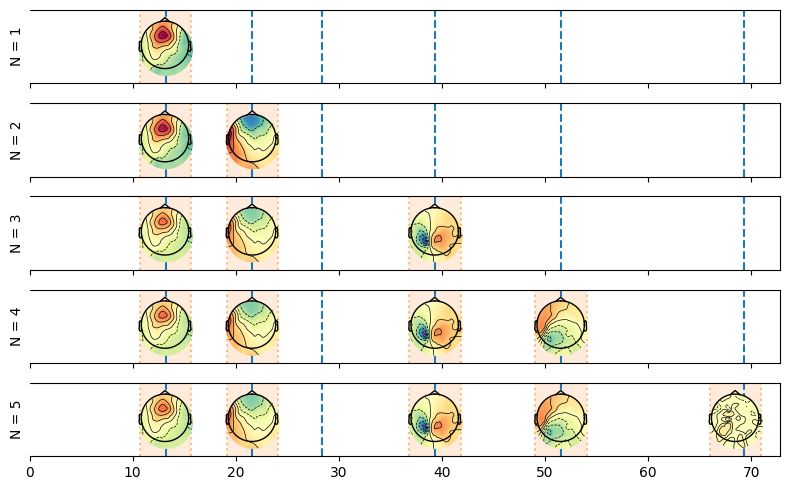

In [25]:
fig, axes = plt.subplots(len(model_cumulative.submodels), 1, figsize=(8, len(model_cumulative.submodels)), sharex=True)

for ax, i in zip(axes, model_cumulative.submodels):
    lkh_i, estimates_i = model_cumulative.submodels[i].transform(trial_data)
    plot_topo_timecourse(epoch_data, estimates_i, info, 
                        times_to_display=np.mean(np.cumsum(sim_source_times, axis=1), axis=0), 
                        magnify=1, ax=ax, colorbar=False)
    ax.set_ylabel(f"N = {model_cumulative.submodels[i].n_events}")
plt.tight_layout()

We can look how the likelihood unfolded. HMP automatically stops for the best model:

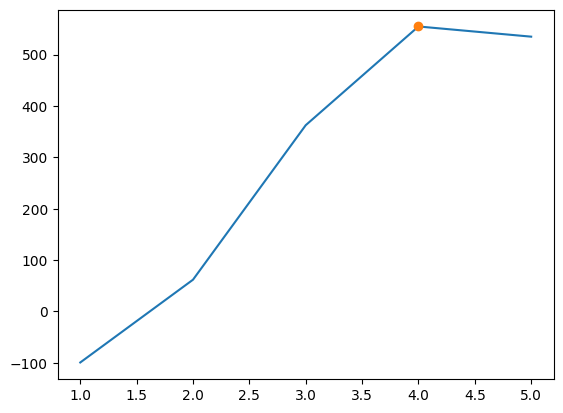

In [26]:
cumulative_res = np.array([np.array([model_cumulative.submodels[x].n_events, model_cumulative.submodels[x].lkhs[0]]) for x in model_cumulative.submodels])
plt.plot(cumulative_res[:,0], cumulative_res[:,1])
plt.plot(model_cumulative.final_model.n_events, model_cumulative.final_model.lkhs, 'o', label='Fitted model likelihood')

As you can see the cumulative estimation missed the third event. This is likely because the third event is very close to the second one and the algorithm instead jumped to the fourth event. This is a behavior that we do not regularly observe on real data, nevertheless to avoid this behavior we can use the `by_sample` argument to fit the model sample by sample instead of jumping to the next highest likelihood event and ignoring the samples in between.


### By sample

  0%|          | 0/71 [00:00<?, ?it/s]

Transition event 1 found around time 130.0
Transition event 2 found around time 220.0
Transition event 3 found around time 520.0
Transition event 4 found around time 520.0
Transition event 5 found around time 520.0

All events found, refitting final combination.
Estimating 5 events model


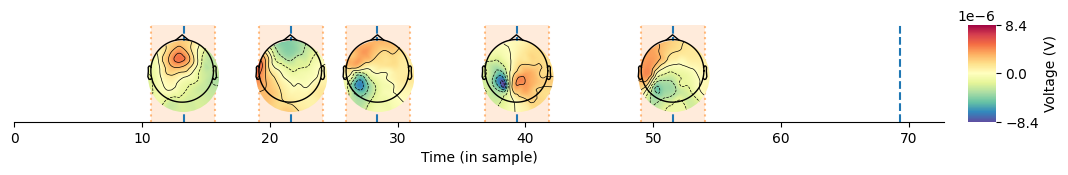

In [27]:
model_cumulative = CumulativeMethod(event_properties, by_sample=True)
model_cumulative.fit(trial_data)
ll_cumulative, estimates_cumulative = model_cumulative.final_model.transform(trial_data)
plot_topo_timecourse(epoch_data, estimates_cumulative, info, 
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)